In [10]:
# ===============================================
# 0. Imports
# ===============================================
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from transformers import AutoTokenizer, AutoModel
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# ===============================================
# 1. Load dataset
# ===============================================
df = pd.read_csv("cancer_cleaned_trimmed.csv")
X = df["cleaned_text"].astype(str)
y = df["label"].astype(int)

In [12]:
# ===============================================
# 2. Train / Validation / Test split
# ===============================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 600
Validation size: 200
Test size: 200


In [13]:
# ===============================================
# 3. TF-IDF + Traditional Models (10-fold CV)
# ===============================================

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

models = {
    "SVM (LinearSVC)": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=300, n_jobs=-1),
    "Naive Bayes": MultinomialNB(),
    "kNN": KNeighborsClassifier(n_neighbors=5, metric="cosine"),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        num_class=len(np.unique(y)),
        eval_metric="mlogloss",
        n_jobs=-1
    ),
    "SGD": SGDClassifier(loss="hinge", random_state=42)
}

pipelines = {
    name: Pipeline([
        ("tfidf", tfidf),
        ("clf", model)
    ])
    for name, model in models.items()
}

def evaluate_models(pipelines, X_train, y_train, cv=10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    results = []
    confusion_mats = {}

    for name, pipe in pipelines.items():
        print(f"\n=== Evaluating {name} ===")

        y_pred = cross_val_predict(pipe, X_train, y_train, cv=skf, n_jobs=-1)

        acc = accuracy_score(y_train, y_pred)
        prec = precision_score(y_train, y_pred, average="macro")
        f1 = f1_score(y_train, y_pred, average="macro")

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision_macro": prec,
            "F1_macro": f1
        })

        confusion_mats[name] = confusion_matrix(y_train, y_pred)

        print(f"Accuracy: {acc:.4f}")
        print(f"Macro Precision: {prec:.4f}")
        print(f"Macro F1: {f1:.4f}")

    return pd.DataFrame(results), confusion_mats

results_df, confusion_mats = evaluate_models(pipelines, X_train, y_train)
print("\n=== Traditional Models Summary ===")
print(results_df.sort_values(by="F1_macro", ascending=False))


=== Evaluating SVM (LinearSVC) ===
Accuracy: 0.9483
Macro Precision: 0.9487
Macro F1: 0.9483

=== Evaluating Random Forest ===
Accuracy: 0.9433
Macro Precision: 0.9436
Macro F1: 0.9430

=== Evaluating Naive Bayes ===
Accuracy: 0.8733
Macro Precision: 0.8778
Macro F1: 0.8741

=== Evaluating kNN ===
Accuracy: 0.7433
Macro Precision: 0.7479
Macro F1: 0.7430

=== Evaluating XGBoost ===
Accuracy: 0.9333
Macro Precision: 0.9342
Macro F1: 0.9334

=== Evaluating SGD ===
Accuracy: 0.9400
Macro Precision: 0.9403
Macro F1: 0.9397

=== Traditional Models Summary ===
             Model  Accuracy  Precision_macro  F1_macro
0  SVM (LinearSVC)  0.948333         0.948743  0.948288
1    Random Forest  0.943333         0.943589  0.943049
5              SGD  0.940000         0.940291  0.939673
4          XGBoost  0.933333         0.934196  0.933437
2      Naive Bayes  0.873333         0.877837  0.874095
3              kNN  0.743333         0.747907  0.742987


In [14]:
# ===============================================
# 4. BERT: Prepare model
# ===============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_name)
bert_model = AutoModel.from_pretrained(bert_name).to(device)
bert_model.eval()

Using device: cpu


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [15]:
# ===============================================
# 5. BERT Encoding Function
# ===============================================
def bert_encode(texts, batch_size=16, max_length=256):
    all_embeddings = []
    if not isinstance(texts, (list, tuple)):
        texts = list(texts)

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            enc = tokenizer(
                batch, padding=True, truncation=True,
                max_length=max_length, return_tensors="pt"
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            outputs = bert_model(**enc)
            cls_vec = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_vec)

    return np.vstack(all_embeddings)

In [16]:
# ===============================================
# 6. BERT encode Train / Val / Test
# ===============================================
print("\nEncoding texts using BERT...")
X_train_bert = bert_encode(X_train)
X_val_bert = bert_encode(X_val)
X_test_bert = bert_encode(X_test)

print("BERT Train:", X_train_bert.shape)
print("BERT Val:", X_val_bert.shape)
print("BERT Test:", X_test_bert.shape)


Encoding texts using BERT...
BERT Train: (600, 768)
BERT Val: (200, 768)
BERT Test: (200, 768)


In [17]:
# ===============================================
# 7. BERT + Logistic Regression
# ===============================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

clf_bert = LogisticRegression(max_iter=1000, n_jobs=-1, multi_class="multinomial")
clf_bert.fit(X_train_bert, y_train)

y_val_pred = clf_bert.predict(X_val_bert)
val_acc = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="macro")
val_f1 = f1_score(y_val, y_val_pred, average="macro")

print("\n=== BERT Validation Results ===")
print("Validation Accuracy:", round(val_acc, 4))
print("Validation Macro Precision:", round(val_precision, 4))
print("Validation Macro F1:", round(val_f1, 4))
print("\nValidation classification report:")
print(classification_report(y_val, y_val_pred, digits=3))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== BERT Validation Results ===
Validation Accuracy: 0.855
Validation Macro Precision: 0.8686
Validation Macro F1: 0.8578

Validation classification report:
              precision    recall  f1-score   support

           0      0.720     0.900     0.800        40
           1      0.800     0.800     0.800        40
           2      1.000     0.825     0.904        40
           3      0.850     0.850     0.850        40
           4      0.973     0.900     0.935        40

    accuracy                          0.855       200
   macro avg      0.869     0.855     0.858       200
weighted avg      0.869     0.855     0.858       200



In [18]:
# ===============================================
# 8. Final training on Train+Val, test on Test (BERT)
# ===============================================

from sklearn.metrics import precision_score

X_trainval_bert = np.vstack([X_train_bert, X_val_bert])
y_trainval = pd.concat([y_train, y_val])

clf_bert_final = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    multi_class="multinomial"
)
clf_bert_final.fit(X_trainval_bert, y_trainval)

# Test evaluation for BERT
y_test_pred_bert = clf_bert_final.predict(X_test_bert)

bert_test_acc = accuracy_score(y_test, y_test_pred_bert)
bert_test_precision = precision_score(y_test, y_test_pred_bert, average="macro")
bert_test_f1 = f1_score(y_test, y_test_pred_bert, average="macro")

print("\n=== BERT Test Results ===")
print("Test Accuracy:", round(bert_test_acc, 4))
print("Test Macro Precision:", round(bert_test_precision, 4))
print("Test Macro F1:", round(bert_test_f1, 4))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_bert, digits=3))



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== BERT Test Results ===
Test Accuracy: 0.795
Test Macro Precision: 0.8016
Test Macro F1: 0.7976

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.675     0.675     0.675        40
           1      0.780     0.800     0.790        40
           2      0.946     0.875     0.909        40
           3      0.659     0.725     0.690        40
           4      0.947     0.900     0.923        40

    accuracy                          0.795       200
   macro avg      0.802     0.795     0.798       200
weighted avg      0.802     0.795     0.798       200



In [19]:
# ===============================================
# 9. Model Selection Table (for choosing champion model)
# ===============================================

# Traditional models: 10-fold CV on Train
# BERT: performance on Validation set

model_selection_df = results_df.copy()
model_selection_df["Source"] = "CV on Train"

bert_selection_row = {
    "Model": "BERT + Logistic Regression",
    "Accuracy": val_acc,
    "Precision_macro": val_precision,
    "F1_macro": val_f1,
    "Source": "Validation"
}

model_selection_df = pd.concat(
    [model_selection_df, pd.DataFrame([bert_selection_row])],
    ignore_index=True
)

print("\n=== Model Selection ===")
print(model_selection_df.sort_values(by="F1_macro", ascending=False))



=== Model Selection ===
                        Model  Accuracy  Precision_macro  F1_macro  \
0             SVM (LinearSVC)  0.948333         0.948743  0.948288   
1               Random Forest  0.943333         0.943589  0.943049   
5                         SGD  0.940000         0.940291  0.939673   
4                     XGBoost  0.933333         0.934196  0.933437   
2                 Naive Bayes  0.873333         0.877837  0.874095   
6  BERT + Logistic Regression  0.855000         0.868595  0.857835   
3                         kNN  0.743333         0.747907  0.742987   

        Source  
0  CV on Train  
1  CV on Train  
5  CV on Train  
4  CV on Train  
2  CV on Train  
6   Validation  
3  CV on Train  


In [20]:
# ===== Final Testing for Champion Model: SVM =====

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

svm_champion = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True
    )),
    ("clf", LinearSVC())
])

# Train + Validation
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# Train champion
svm_champion.fit(X_trainval, y_trainval)

# Final Test predictions
y_test_pred_svm = svm_champion.predict(X_test)

# Metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report

test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
test_precision_svm = precision_score(y_test, y_test_pred_svm, average="macro")
test_f1_svm = f1_score(y_test, y_test_pred_svm, average="macro")

print("=== Final Test Results: SVM (Champion Model) ===")
print("Test Accuracy:", test_acc_svm)
print("Test Macro Precision:", test_precision_svm)
print("Test Macro F1:", test_f1_svm)
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_svm, digits=3))


=== Final Test Results: SVM (Champion Model) ===
Test Accuracy: 0.95
Test Macro Precision: 0.9504733493474277
Test Macro F1: 0.9496486504343249

Classification Report:

              precision    recall  f1-score   support

           0      0.974     0.950     0.962        40
           1      0.927     0.950     0.938        40
           2      0.975     0.975     0.975        40
           3      0.946     0.875     0.909        40
           4      0.930     1.000     0.964        40

    accuracy                          0.950       200
   macro avg      0.950     0.950     0.950       200
weighted avg      0.950     0.950     0.950       200



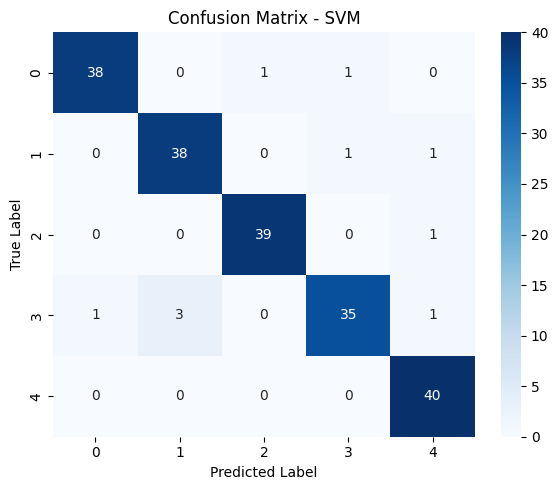

In [21]:
# ===== Confusion Matrix for SVM =====
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
class_names = ["Colon_Cancer", "Liver_Cancer", "Lung_Cancer", "Stomach_Cancer", "Thyroid_Cancer"]